<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/figure8_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 torch.Size([100, 1000, 2])
100 to

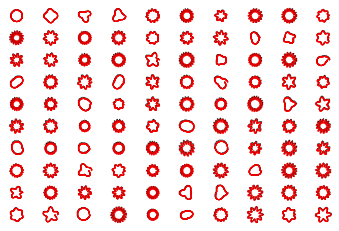

In [ ]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        radii[i,:] += a
        
    assert torch.min(radii)>0
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None, i = 0):
    if len(sample) == 3:
      img = sample[0,:,:].squeeze().cpu().numpy()
    else:
      img = sample[i,0,:,:].squeeze().cpu().numpy()
      
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints
            h0 = None
            c0 = None
            X = []
            Y = []
            out = model(sample.cuda()).reshape(100,1000,2)
            print('loss',mse_cnn(sample.cuda(),labels.cuda()))
            X = out[i,:1000,0]
            Y = out[i,-1000:,1]
            
            predres = 1000
            s = [.001 for x in range(predres)]
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        print(len(labels),labels.shape)
        if len(labels)==2:
          X = labels[:,0]
          Y = labels[:,1]
          s = [.001 for x in range(numpoints)]
          c = ['red' for x in range(numpoints)]
        else:
          X = labels[i,:,0]
          Y = labels[i,:,1]
          s = [.001 for x in range(numpoints)]
          c = ['red' for x in range(numpoints)]

        ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0][0,:,:]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0
    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]

        #assert canvas.shape == (side,side) or canvas.shape == (len(idx))
        
        points = self.values["points"]
        points = points[idx,:]
        if len(canvas.shape) == 2:
          canvas = torch.stack([canvas,canvas,canvas],dim=0)
        else:
          canvas = torch.stack([canvas,canvas,canvas],dim=1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        sample, labels = dataset[0:100]
        for i in range(100):
          plt.subplot(10,10,i+1)
          plot_all(sample = sample,model=model, labels = labels,i = i)
          plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [ ]:
dataset[0:10][0].shape

torch.Size([10, 3, 32, 32])

In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
train_dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    train_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=train_dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.do1 = nn.Dropout()
        self.fc = nn.Sequential(nn.Linear(512 * block.expansion, num_classes*100),nn.ReLU(),nn.Dropout(),nn.Linear(num_classes*100,num_classes),nn.Sigmoid()) 
        #self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.do1(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = x*32.0
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """

    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


In [ ]:

model = resnet18(pretrained=False,progress=True, num_classes = 2000).cuda()
#model = wide_resnet101_2(pretrained=False,progress=True, num_classes = 2000).cuda()

In [ ]:

def mse_cnn(input, target):
  out = model(input)
  out = out.reshape(target.shape)#64, 1000, 2
  #print('mse_cnn',out.shape,target.shape)
  
  return torch.mean((out-target)**2)
  

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))#ideal


In [ ]:
for epoch in range(100):
  for x,y in loader_train:
    optimizer.zero_grad()
    x = x.cuda()
    y = y.cuda()
    loss = mse_cnn(x,y)
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss)
    #print(out.shape)
  
  

epoch 0 loss tensor(97.8538, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1 loss tensor(30.9098, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 2 loss tensor(14.5086, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 3 loss tensor(5.3509, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 4 loss tensor(3.7372, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 5 loss tensor(3.2251, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 6 loss tensor(2.8405, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 7 loss tensor(2.5504, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 8 loss tensor(2.4562, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 9 loss tensor(2.5795, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 10 loss tensor(2.3316, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 11 loss tensor(2.4005, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 12 loss tensor(2.2214, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 13 loss tensor(3.4793, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 14 loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))#ideal


In [ ]:
for epoch in range(200):
  for x,y in loader_train:
    optimizer.zero_grad()
    x = x.cuda()
    y = y.cuda()
    loss = mse_cnn(x,y)
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss)
    #print(out.shape)
  
  

epoch 0 loss tensor(0.2001, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1 loss tensor(0.1370, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 2 loss tensor(0.2670, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 3 loss tensor(0.1053, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 4 loss tensor(0.1661, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 5 loss tensor(0.1698, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 6 loss tensor(0.1441, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 7 loss tensor(0.1687, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 8 loss tensor(0.2354, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 9 loss tensor(0.1283, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 10 loss tensor(0.1279, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 11 loss tensor(0.1299, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 12 loss tensor(0.1370, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 13 loss tensor(0.2004, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 14 loss te

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.000001, betas = (.9,.999))#ideal


In [ ]:
for epoch in range(100):
  for x,y in loader_train:
    optimizer.zero_grad()
    x = x.cuda()
    y = y.cuda()
    loss = mse_cnn(x,y)
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss)
  
    #print(out.shape)
  
  

epoch 0 loss tensor(0.0580, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1 loss tensor(0.0679, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 2 loss tensor(0.0603, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 3 loss tensor(0.0432, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 4 loss tensor(0.0896, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 5 loss tensor(0.0429, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 6 loss tensor(0.1006, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 7 loss tensor(0.0477, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 8 loss tensor(0.0450, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 9 loss tensor(0.0491, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 10 loss tensor(0.0707, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 11 loss tensor(0.0869, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 12 loss tensor(0.0625, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 13 loss tensor(0.0486, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 14 loss te

loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
loss tensor(0.5290, device='cuda:0')
l

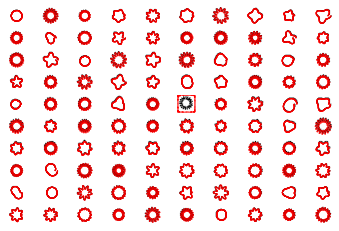

In [ ]:
model = model.eval()
#dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('cnn-resn18-mod-2WFCL.png',train_dataset, model = model)


In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 100)
loader_test = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [ ]:
model = model.eval()
for x,y in loader_test:
  x = x.cuda()
  y = y.cuda()
  loss = mse_cnn(x,y)
  print('validation loss',loss)
  break
  

validation loss tensor(0.5533, device='cuda:0', grad_fn=<MeanBackward0>)


need to avoid overfitting
https://discuss.pytorch.org/t/inject-dropout-into-resnet-or-any-other-network/66322/2

loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
loss tensor(0.5545, device='cuda:0')
l

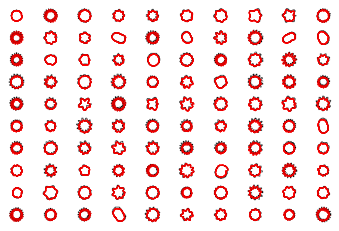

In [ ]:
model = model.eval()
#dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('cnn-resn18-mod-2WFCL.png',dataset, model = model)


max min x tensor(30.3000) tensor(1.5495)
max min y tensor(27.9582) tensor(2.9384)


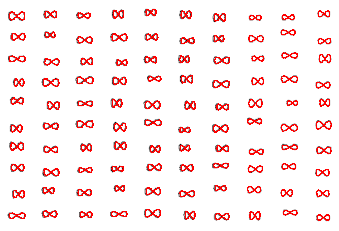

In [ ]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def f8_matrix(length = 10):
    
    canvas = torch.zeros((length,side, side))
    x = torch.zeros((length,numpoints))
    y = torch.zeros((length,numpoints))
        
    ###

    for i in range(length):
      t = torch.linspace(0,2*3.14159,numpoints)
      x[i,:] = t.cos()
      y[i,:] = t.sin()*t.cos()

      WIDTH = 14
      randMultx = np.random.uniform(8.0,WIDTH-.1)
      randMulty = np.random.uniform(8.0,WIDTH-.1)

      maxaddx = WIDTH-randMultx
      maxaddy = 3.0+WIDTH-randMulty
      
      assert maxaddx >0
      assert maxaddy >0

      randAddx = np.random.uniform(-maxaddx,maxaddx)
      randAddy = np.random.uniform(-maxaddy,maxaddy)

      randMultSinx = np.random.uniform(.25,.5)
      randMultSiny = np.random.uniform(.25,.5)
      randMultFreqSinx = np.random.uniform(10.0,20.0)
      randMultFreqSiny = np.random.uniform(10.0,20.0)
      #randAddSinx = np.random.uniform(0.0,1.0)
      #randAddSiny = np.random.uniform(0.0,1.0)
      xsin = randMultSiny*((t*randMultFreqSinx).sin())#+randAddSinx
      ysin = randMultSiny*((t*randMultFreqSiny).sin())#+randAddSiny
      #print('maxxsin',torch.max(xsin))
      x[i,:] = (x[i,:]*randMultx)+16+randAddx+xsin
      y[i,:] = (y[i,:]*randMulty)+16+randAddy+ysin
  
    assert torch.max(x).item() < 32
    assert torch.min(x).item() > 0
    assert torch.max(y).item() < 32
    assert torch.min(y).item() > 0
    
    print("max min x",torch.max(x),torch.min(x))
    print("max min y",torch.max(y),torch.min(y))
    ###
    
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def f8_plot_all( sample = None, model = None, labels = None):
    if len(sample.shape) == 3:
      img = sample[0,:,:].squeeze().cpu().numpy()
    else:
      img = sample[i,0,:,:].squeeze().cpu().numpy()
      
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints
            h0 = None
            c0 = None
            X = []
            Y = []
            print('before')
            out = model(sample.unsqueeze(0).cuda()).reshape(1000,2)
            print('after')
            print('loss',mse_cnn(sample.unsqueeze(0).cuda(),labels.unsqueeze(0).cuda()))
            X = out[:1000,0]
            Y = out[-1000:,1]
            print('1')
            predres = 1000
            s = [.001 for x in range(predres)]
            print('2')
            assert len(s) == predres
            print('3')
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            print('4')
            ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),c='r',s=.001)
            print('5')
            plt.gca().add_artist(ascatter)
    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class Figure8Dataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = f8_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0][0,:,:]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        if len(canvas.shape) == 2:
          canvas = torch.stack([canvas,canvas,canvas],dim=0)
        else:
          canvas = torch.stack([canvas,canvas,canvas],dim=1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            f8_plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=1200)
        
figure8dataset = Figure8Dataset(length = 100)

Figure8Dataset.displayCanvas('figure8dataset.png',figure8dataset, model = None)


In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
f8_train_dataset = Figure8Dataset(length = 64*1)
f8_loader_train = data.DataLoader(
    f8_train_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=f8_train_dataset),
    num_workers=4)


max min x tensor(30.3016) tensor(1.6502)
max min y tensor(27.9482) tensor(3.9459)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = .00001)

In [ ]:
model = model.eval()
sum = 0.0
count = 0.0
for epoch in range(1):
  for x,y in f8_loader_train:
    #optimizer.zero_grad()
    x = x.cuda()
    y = y.cuda()
    loss = mse_cnn(x,y)
    sum += loss.item()
    count+=1.0
    #loss.backward()
    #optimizer.step()
  print('epoch',epoch,'loss',loss)
    #print(out.shape)


print('f8 loss',(float(sum))/(float(count)))  

epoch 0 loss tensor(36.0346, device='cuda:0', grad_fn=<MeanBackward0>)
f8 loss 36.03455352783203


before
after
loss tensor(35.9242, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(45.1869, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(36.2501, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(36.6633, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(37.4555, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(25.3736, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(40.4694, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(39.5637, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(32.7380, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(30.2348, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(33.2306, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(34.4112, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(31.8116, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(34.4826, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(38.1817, device='cuda:0')
1
2
3
4
5
before
after
loss tensor(29.4200, device='cuda:0')
1
2
3
4
5
before
after
loss tensor

IndexError: ignored

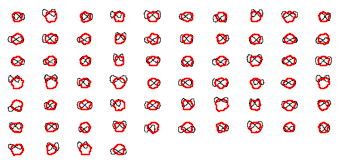

In [ ]:
Figure8Dataset.displayCanvas('figure8dataset.png',f8_train_dataset, model = model)
